In [ ]:
!pip install dipy
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 14.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.1 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive
mount_path = '/content/drive'
drive_path = mount_path+"/MyDrive/dti-transformer/code/model"
results_path = drive_path+"/results"
drive.mount(mount_path)
os.chdir(drive_path)

Mounted at /content/drive


In [ ]:
# Daniel Bandala @ mar-2023
# dti-model training script
# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
# diffussion image processing
from dipy.io.image import load_nifti
# import torch libraries
import torch   
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR   
# import dataset auxiliar libraries
from data_loader import *
from tqdm.notebook import tqdm
# import model
from dti_model import DiffusionTensorModel

In [ ]:
# set plot parameters
plt.rcParams.update({'font.size': 20})

In [ ]:
# folders dataset
main_dir = '/content/drive/MyDrive/dti-transformer/dti_data/HCP'

In [ ]:
# read difussion data
data, affine = load_nifti(main_dir+'/case_02/input/DWI_opt.nii.gz')
data.shape

(140, 140, 96, 15)

In [ ]:
# read difussion data
output, _ = load_nifti(main_dir+'/case_02/output/DTI_FA.nii.gz')
output.shape

(140, 140, 96)

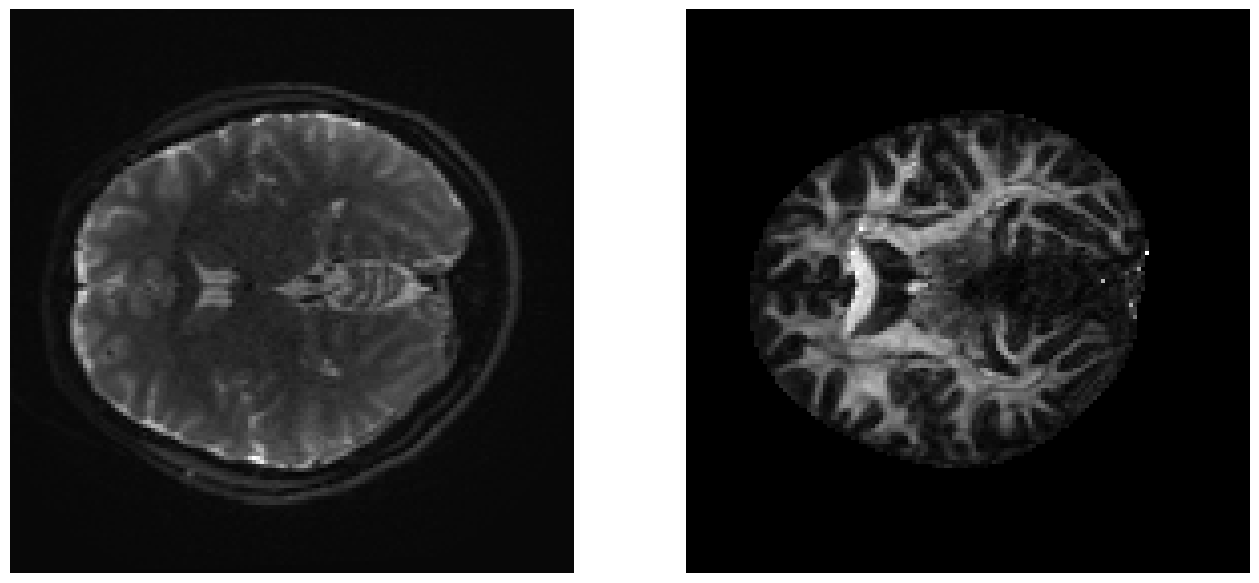

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, 48, 0], cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(output[:, :, 48], cmap='gray', origin='lower')

In [ ]:
# input channels
signals = 15
# define training parameters
batches = 10
epochs = 180
test_size = 0.1
start_epoch = 0
# optimizer parameters
lr = 2e-4
weight_decay = 1e-4
gamma = 0.9 #for learning rate scheduler
step_size = 1
seed = 24
# select available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# folders dataset
main_dir = ['/content/drive/MyDrive/dti-transformer/dti_data/HCP',
            '/content/drive/MyDrive/dti-transformer/dti_data/ADNI']

In [ ]:
# load dataset
maps = ["FA"] #"MD","MO","L1","L2","L3"
train_list, valid_list, train_loader, valid_loader = get_dataset(main_dir, test_size, batches, maps=maps, signals=signals, dti_folder='output')

Dataset size: 59
Train Data: 53
Validation Data: 6


In [ ]:
# load model
model = DiffusionTensorModel(
    in_chans=signals,
    out_chans=len(maps),
    img_size=140,
    embed_dim=64,
    n_heads=[1,2,4,8],
    mlp_ratio=[2,2,4,4],
    reduction_ratio=1,
    depth_prob=0.2,
    tanh_output=False
)
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# scheduler
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [ ]:
device
# copy model to gpu
_ = model.to(device)

In [ ]:
# enable training graphics widget
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
# model weights path
continue_training = True
model_path = results_path+"/dti_fa.weights"
ch_path = results_path+"/opt.pt.tar"

In [ ]:
# load model and parameters to keep training
if continue_training:
    checkpoint = torch.load(ch_path)
    start_epoch = int(checkpoint['epoch'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#model = torch.load(model_path, map_location=torch.device(device))

In [ ]:
# set model on training mode
_ = model.train()
# get trainable parameters
print("Trainable parameters: ", get_params(model))

Trainable parameters:  35214591


In [ ]:
#start training
ep_loss = [] 
# error variables
prev_error = float("inf")
#seed_everything(seed)
for epoch in range(start_epoch, epochs):
    epoch_loss = 0.
    for batch_data, batch_label in tqdm(train_loader):
        batch_range = list(range(batch_data.shape[0]))
        shuffle(batch_range)
        for i in batch_range:
            slice_data = batch_data[i].to(device)
            slice_label = batch_label[i].to(device)
            samples_t = slice_data.shape[0]
            s_counter = 0
            slice_range = list(range(samples_t))
            shuffle(slice_range)
            for s in slice_range:
                s_counter += 1
                data = slice_data[s]
                label = slice_label[s]

                # forward - evaluate model
                output = model(data)
                loss = criterion(output, label)
                # backward propagation
                loss.backward()

                # loss average
                epoch_loss += loss.item()

                #if s_counter%48==0:
            # optimize model - update network weights
            optimizer.step()
            # zero the parameter gradient
            optimizer.zero_grad()

    # calculate loss on validation set
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_data, batch_label in valid_loader:
            for i in range(batch_data.shape[0]):
                slice_data = batch_data[i].to(device)
                slice_label = batch_label[i].to(device)
                samples_v = slice_data.shape[0]
                for s in range(samples_v):
                    data = slice_data[s]
                    label = slice_label[s]
                    # evaluate model on validation case
                    val_output = model(data)
                    val_loss = criterion(val_output, label)
                    # validation loss
                    epoch_val_loss += val_loss.item()

    # append to epoch array
    epoch_loss = epoch_loss/(len(train_list)*samples_t)
    epoch_val_loss = epoch_val_loss/(len(valid_list)*samples_v)
    ep_loss.append([epoch_loss,epoch_val_loss])
    # adjust learning rate in case the error did not decrease
    if prev_error<epoch_loss:
        scheduler.step()
    # assign epoch loss to next comparisson
    prev_error = epoch_loss
    # save loss graph status
    fig=plt.figure(figsize=(16,8))
    plt.ion()
    plt.plot(range(1, len(ep_loss) + 1), ep_loss, linewidth=4)
    plt.title("Average loss function for each epoch")
    plt.ylabel("Error")
    plt.xlabel("Epoch")
    plt.legend(['Training loss', 'Validation loss'],loc="upper right")
    #plt.ylim([0, 2])
    plt.grid()
    try:
        plt.savefig(results_path+"/avg_loss.png")
    except Exception as e:
        print("Error saving loss graph")
        drive.mount(mount_path, force_remount=True)
        os.chdir(drive_path)
    finally:
        plt.close(fig)
    # save error list
    try:
        pd.DataFrame(ep_loss).to_csv(results_path+"/training_loss.csv",index=False, header=False)
    except Exception as e:
        print("Error saving loss data")
        drive.mount(mount_path, force_remount=True)
        os.chdir(drive_path)
    finally:
        plt.close(fig)
    # save model weights and training parameters
    try:
        torch.save({'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict()
                    }, ch_path)
    except Exception as e:
        print("Error saving model")
        drive.mount(mount_path, force_remount=True)
        os.chdir(drive_path)
    # print epoch metrics
    print(
        f"Epoch: {epoch+1}  -  train loss: {epoch_loss:.8f}  -  valid loss: {epoch_val_loss:.8f} \n"
    )
# return model to cpu
_ = model.to("cpu")
# save final model
torch.save(model.state_dict(), model_path)
# complete
print("\nTraining finished")

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 121  -  train loss: 0.00139027  -  valid loss: 0.00147335 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 122  -  train loss: 0.00139171  -  valid loss: 0.00145498 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 123  -  train loss: 0.00138758  -  valid loss: 0.00147065 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 124  -  train loss: 0.00138990  -  valid loss: 0.00146685 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 125  -  train loss: 0.00138400  -  valid loss: 0.00145645 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 126  -  train loss: 0.00138417  -  valid loss: 0.00145697 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 127  -  train loss: 0.00138509  -  valid loss: 0.00146369 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 128  -  train loss: 0.00138499  -  valid loss: 0.00146086 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 129  -  train loss: 0.00137919  -  valid loss: 0.00146123 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 130  -  train loss: 0.00137618  -  valid loss: 0.00147452 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 131  -  train loss: 0.00137773  -  valid loss: 0.00145973 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 132  -  train loss: 0.00137713  -  valid loss: 0.00145359 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 133  -  train loss: 0.00137718  -  valid loss: 0.00146046 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 134  -  train loss: 0.00137602  -  valid loss: 0.00146251 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 135  -  train loss: 0.00137937  -  valid loss: 0.00146129 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 136  -  train loss: 0.00137516  -  valid loss: 0.00145722 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 137  -  train loss: 0.00137646  -  valid loss: 0.00146264 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 138  -  train loss: 0.00136971  -  valid loss: 0.00145977 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 139  -  train loss: 0.00137269  -  valid loss: 0.00146054 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 140  -  train loss: 0.00137378  -  valid loss: 0.00146338 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 141  -  train loss: 0.00136984  -  valid loss: 0.00146139 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 142  -  train loss: 0.00136995  -  valid loss: 0.00145614 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 143  -  train loss: 0.00136806  -  valid loss: 0.00145142 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 144  -  train loss: 0.00136725  -  valid loss: 0.00145644 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 145  -  train loss: 0.00136622  -  valid loss: 0.00145540 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 146  -  train loss: 0.00136597  -  valid loss: 0.00146360 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 147  -  train loss: 0.00136765  -  valid loss: 0.00146258 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 148  -  train loss: 0.00136550  -  valid loss: 0.00145952 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 149  -  train loss: 0.00136387  -  valid loss: 0.00146528 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 150  -  train loss: 0.00136615  -  valid loss: 0.00145254 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 151  -  train loss: 0.00136631  -  valid loss: 0.00145476 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 152  -  train loss: 0.00136296  -  valid loss: 0.00146812 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 153  -  train loss: 0.00136339  -  valid loss: 0.00146821 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 154  -  train loss: 0.00136795  -  valid loss: 0.00146118 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 155  -  train loss: 0.00136297  -  valid loss: 0.00145344 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 156  -  train loss: 0.00136456  -  valid loss: 0.00145948 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 157  -  train loss: 0.00136313  -  valid loss: 0.00145433 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 158  -  train loss: 0.00136166  -  valid loss: 0.00145877 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 159  -  train loss: 0.00136490  -  valid loss: 0.00145740 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 160  -  train loss: 0.00135861  -  valid loss: 0.00146121 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 161  -  train loss: 0.00136005  -  valid loss: 0.00145480 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 162  -  train loss: 0.00135940  -  valid loss: 0.00145573 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 163  -  train loss: 0.00136054  -  valid loss: 0.00145649 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 164  -  train loss: 0.00136075  -  valid loss: 0.00145324 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 165  -  train loss: 0.00136027  -  valid loss: 0.00145303 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 166  -  train loss: 0.00136113  -  valid loss: 0.00145673 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 167  -  train loss: 0.00135804  -  valid loss: 0.00145675 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 168  -  train loss: 0.00135928  -  valid loss: 0.00145179 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 169  -  train loss: 0.00135941  -  valid loss: 0.00145166 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 170  -  train loss: 0.00135746  -  valid loss: 0.00145383 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 171  -  train loss: 0.00135770  -  valid loss: 0.00145736 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 172  -  train loss: 0.00135659  -  valid loss: 0.00145560 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 173  -  train loss: 0.00135837  -  valid loss: 0.00145453 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 174  -  train loss: 0.00135622  -  valid loss: 0.00145149 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 175  -  train loss: 0.00136037  -  valid loss: 0.00145424 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 176  -  train loss: 0.00135912  -  valid loss: 0.00145250 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 177  -  train loss: 0.00135602  -  valid loss: 0.00145081 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 178  -  train loss: 0.00135618  -  valid loss: 0.00145494 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 179  -  train loss: 0.00135963  -  valid loss: 0.00145305 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 180  -  train loss: 0.00135503  -  valid loss: 0.00145558 


Training finished


In [ ]:
# evaluate model
data, label = data_preprocessing(valid_list[2], maps=maps, signals=signals)
data_val, label_val = data[48], label[48]

In [ ]:
_ = model.to("cpu")
model.eval()
with torch.no_grad():
    output = model(data_val)

In [ ]:
print("Data: ",data.shape)
print("Label: ",label.shape)
print("Data to evaluate: ",data_val.shape)
print("Label to evaluate: ",label_val.shape)
print("Output: ",output.shape)

Data:  torch.Size([96, 15, 140, 140])
Label:  torch.Size([96, 140, 140])
Data to evaluate:  torch.Size([15, 140, 140])
Label to evaluate:  torch.Size([140, 140])
Output:  torch.Size([140, 140])


In [ ]:
# detach data
data_eval_np = data_val.detach().numpy()
label_eval_np = label_val.detach().numpy()
output_eval_np = output.detach().numpy()

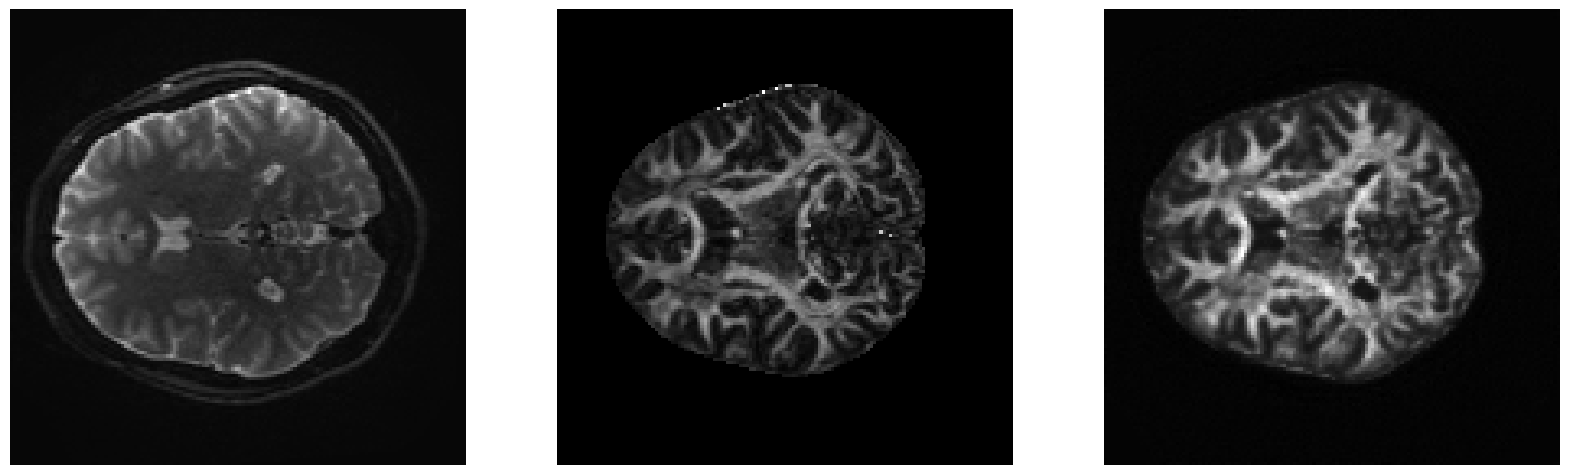

In [ ]:
# print visual evaluation
plt.figure(figsize=(20,12))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(data_eval_np[0], cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(label_eval_np, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(output_eval_np, cmap='gray', origin='lower')
plt.savefig(results_path+"/fa_result.png")

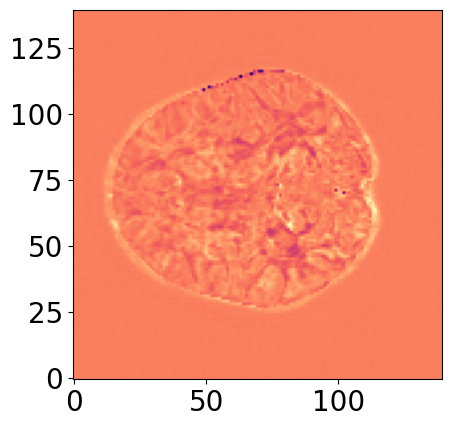

In [ ]:
res = label_eval_np-output_eval_np
plt.imshow(res, cmap='magma_r', origin='lower')